# Two-Body Orbit Problem

## The Euler-Lagrange equations

For the two-body system, the Lagrangian (with generalized coordinates $x_1$ , $y_1$ , $x_2$ and $y_2$) is:

$\begin{align}
  \mathcal{L} = T - U = \frac{1}{2} m_1 (\dot x_1^2 + \dot y_1^2) + \frac{1}{2} m_2 (\dot x_2^2 + \dot y_2^2) + \frac{G m_1 m_2}{\sqrt{(x_1 - x_2)^2+(y_1 - y_2)^2}}
\end{align}$

Now, letting

$\begin{align}
  r = \big((x_1-x_2)^2 + (y_1 - y_2)^2\big)^{\frac{1}{2}}
\end{align}$

the Euler-Lagrange equations are

$\begin{align}
 &\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_1} = \frac{\partial\mathcal L}{\partial x_1}
 \quad\Longrightarrow\quad
 \ddot x_1 = \frac{-G m_2 (x_1 - x_2)}{r^3} \\
 &\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_1} = \frac{\partial\mathcal L}{\partial y_1}
 \quad\Longrightarrow\quad
 \ddot y_1 = \frac{-G m_2 (y_1 - y_2)}{r^3} \\
 &\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot x_2} = \frac{\partial\mathcal L}{\partial x_2}
 \quad\Longrightarrow\quad
 \ddot x_2 = \frac{G m_1 (x_1 - x_2)}{r^3} \\
 &\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot y_2} = \frac{\partial\mathcal L}{\partial y_2}
 \quad\Longrightarrow\quad
 \ddot y_2 = \frac{G m_1 (y_1 - y_2)}{r^3}\\
\end{align}$

These equations are implemented in the method dy_dt in the TwoBodyOrbit class.

## Leapfrog Method to Solve Differential Equations
The leapfrog method is a better solver for periodic equations such as those of an orbit. It does better by evaluating $\dot x_1$ at a halfway time step before and after the $x_1$ evaluation (and similarly for the other variables), which is both more accurate and incorporates time reversal: 

$\begin{align}
   &\dot x_{1,i+1/2} = \dot x_{1,i} + \frac{d\mathbf{y}_i[1]}{dt}  \Delta t/2 \\
   &x_{1,i+1} = x_i + \dot x_{1,i+1/2}  \Delta t  \\
   &\dot x_{1,i+1} = \dot x_{1,i+1/2} + \frac{d\mathbf{y}_{i+1}[1]}{dt}  \Delta t/2 \\
\end{align}$

These equations work for $x_1$, $y_1$, $x_2$, and $y_2$ by using the appropriate entry from $\frac{d\mathbf{y}}{dt}$. For $x_1$, we want the entry which corresponds to $\ddot x_1$, which is $\frac{d\mathbf{y}[1]}{dt}$ (and similarly for the other variables)

## Things to Import

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

## Two Body Orbit Class

In [2]:
class TwoBodyOrbit():
    """
    TwoBodyOrbit class implements the parameters and Lagrange's 
    equations for the two-body problem for gravitational attraction
    between two bodies in Cartesian coordinates.
     
    Parameters
    ----------
    m1 : float
        mass of first pendulum bob
    m2 : float
        mass of second pendulum bob
    G : float
        Universal gravitational constant

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    solve_ode(t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0,
              x2_0, x2_dot_0, y2_0, y2_dot_0, abserr, relerr)
        Solve the ODE using solve_ivp given initial conditions x1_0, x1_dot_0, 
        y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, and y2_dot_0, and a range of 
        t values, t_pts. It solves at a given absolute error, abserr, 
        and relative error, relerr.
    solve_ode_leapfrog(t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0,
                       x2_0, x2_dot_0, y2_0, y2_dot_0)
        Solve the ODE using leapfrog method given initial conditions x1_0, 
        x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, and y2_dot_0, and a 
        range of t values, t_pts.
    calc_E(x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot)
        Calculate the energy given the position, x1, y1, x2, and y2, and
        the velocity, x1_dot, y1_dot, x2_dot, and y2_dot. 
    
    """
    def __init__(self, mass1=1., mass2=1., G=1.
                ):
        self.m1 = mass1
        self.m2 = mass2
        self.G = G
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt dphi1_dot/dt dphi2/dt dphi2_dot/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            An 8-component vector with 
            y[0] = x1 and y[1] = x1_dot
            y[2] = y1 and y[3] = y1_dot
            y[4] = x2 and y[5] = x2_dot
            y[6] = y2 and y[7] = y2_dot
            
        Returns
        -------
        
        """
        # Denominator that shows up in all of the Lagrange equations
        denom = ((y[0]-y[4])**2 + (y[2]-y[6])**2)**(3./2.)
        
        x1_dot = y[1]
        y1_dot = y[3]
        x2_dot = y[5]
        y2_dot = y[7]
        
        # Lagrange's equations
        x1_dot_dot = -self.G * self.m2 * (y[0]-y[4]) / denom
        y1_dot_dot = -self.G * self.m2 * (y[2]-y[6]) / denom
        x2_dot_dot = self.G * self.m1 * (y[0]-y[4]) / denom
        y2_dot_dot = self.G * self.m1 * (y[2]-y[6]) / denom
        
        return x1_dot, x1_dot_dot, y1_dot, y1_dot_dot, \
               x2_dot, x2_dot_dot, y2_dot, y2_dot_dot
    
    def solve_ode(self, t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0,
                  x2_0, x2_dot_0, y2_0, y2_dot_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x1_0, x1_dot_0, y1_0, y1_dot_0, 
             x2_0, x2_dot_0, y2_0, y2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr,
                             method='RK23')
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y

        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def solve_ode_leapfrog(self, t_pts, x1_0, x1_dot_0, y1_0, 
                           y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0):
        """
        Solve the ODE given initial conditions using the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for x1, x1_dot, x1_dot_half, with zeros
        # and similarly for the other 3 variables y1, x2, and y2
        num_t_pts = len(t_pts)
        
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)
        
        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            # first-half action
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            # second-half action
            y = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot
    
    def calc_E(self, x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot):
        """
        This method calculates the energy given the position and velocity 
        """
        T = 1./2. * self.m1 * (x1_dot**2 + y1_dot**2) + \
            1./2. * self.m2 * (x2_dot**2 + y2_dot**2)
        
        U = -self.G * self.m1 * self.m2 * ((x1-x2)**2 + (y1-y2)**2)**(-1./2.)
        
        return T + U

### Plotting Function

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Simple Two-Body Orbit

In [5]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x$', r'$y$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Orbit parameters
mass1 = 1.
mass2 = 1.
G = 1.

# Instantiate a pendulum 
o1 = TwoBodyOrbit(mass1=mass1, mass2=mass2, G=G)

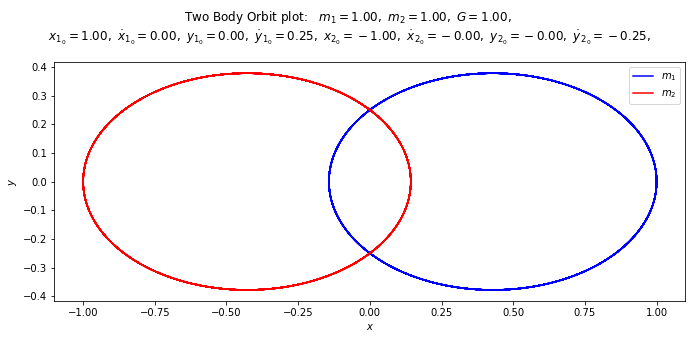

In [6]:
# Initial conditions for the plot
x1_0 = 1.
x1_dot_0 = 0.
y1_0 = 0.
y1_dot_0 = 0.25

# Ensure that the CM is at the origin at rest by setting 
# (m1*r1 + m2*r2)/(m1+m2) = 0 and 
# (m1*r1_dot + m2*r2_dot)/(m1+m2) = 0 
x2_0 = -mass1*x1_0/mass2
x2_dot_0 = -mass1*x1_dot_0/mass2
y2_0 = -mass1*y1_0/mass2
y2_dot_0 = -mass1*y1_dot_0/mass2

x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(t_pts, 
                                                x1_0, x1_dot_0,
                                                y1_0, y1_dot_0,
                                                x2_0, x2_dot_0,
                                                y2_0, y2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,4))
overall_title = 'Two Body Orbit plot:  ' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $G = {G:.2f},$' + \
                '\n' + \
                rf' $x_{{1_0}} = {x1_0:.2f},$' + \
                rf' $\dot x_{{1_0}} = {x1_dot_0:.2f},$' + \
                rf' $y_{{1_0}} = {y1_0:.2f},$' + \
                rf' $\dot y_{{1_0}} = {y1_dot_0:.2f},$' + \
                rf' $x_{{2_0}} = {x2_0:.2f},$' + \
                rf' $\dot x_{{2_0}} = {x2_dot_0:.2f},$' + \
                rf' $y_{{2_0}} = {y2_0:.2f},$' + \
                rf' $\dot y_{{2_0}} = {y2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot gravitational orbits of each mass on the same plot  
ax_a = fig.add_subplot(1,1,1)                  

# Get indices to only plot from t=0 to t=50
start, stop = start_stop_indices(t_pts, t_start, 50.)
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_1$', 
            title=None, 
            ax=ax_a)  
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_2$', 
            title=None, 
            ax=ax_a)    
ax_a.set_aspect(1.)

fig.tight_layout()
fig.savefig('TwoBodyOrbit', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'

## Part (b). $m_2$ >> $m_1$

In [7]:
# Labels for individual plot axes
x_vs_y_labels = (r'$x$', r'$y$')
E_vs_t_labels = (r'$t$', r'$E(t)$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 100.
delta_t = 0.0001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Orbit parameters
mass1 = 1.
mass2 = 1000.
G = 1.

# Instantiate a pendulum 
o2 = TwoBodyOrbit(mass1=mass1, mass2=mass2, G=G)

## Elliptical Orbit: $m_2$>>$m_1$

In [8]:
# Initial conditions for the plot
x1_0 = 10.
x1_dot_0 = 0.
y1_0 = 0.
y1_dot_0 = 7.

x2_0 = -mass1*x1_0/mass2
x2_dot_0 = -mass1*x1_dot_0/mass2
y2_0 = -mass1*y1_0/mass2
y2_dot_0 = -mass1*y1_dot_0/mass2

# Solve the differential equation
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode(t_pts, 
                                                x1_0, x1_dot_0,
                                                y1_0, y1_dot_0,
                                                x2_0, x2_dot_0,
                                                y2_0, y2_dot_0)
# calculate energy difference
E_pts = o2.calc_E(x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot)
E_0 = E_pts[0]
E_rel_diff_pts = np.fabs((E_pts - E_0) / E_0)

# Now solve using the Leapfrog differential solver
x1_LF, x1_dot_LF, y1_LF, y1_dot_LF, x2_LF, x2_dot_LF, y2_LF, y2_dot_LF = \
              o2.solve_ode_leapfrog(t_pts, x1_0, x1_dot_0, y1_0, y1_dot_0,
                                    x2_0, x2_dot_0, y2_0, y2_dot_0)

# calculate energy difference for Leapfrog
E_pts_LF = o2.calc_E(x1_LF, x1_dot_LF, y1_LF, y1_dot_LF, 
               x2_LF, x2_dot_LF, y2_LF, y2_dot_LF)
E_0_LF = E_pts_LF[0]
E_rel_diff_pts_LF = np.fabs((E_pts_LF - E_0_LF) / E_0_LF)

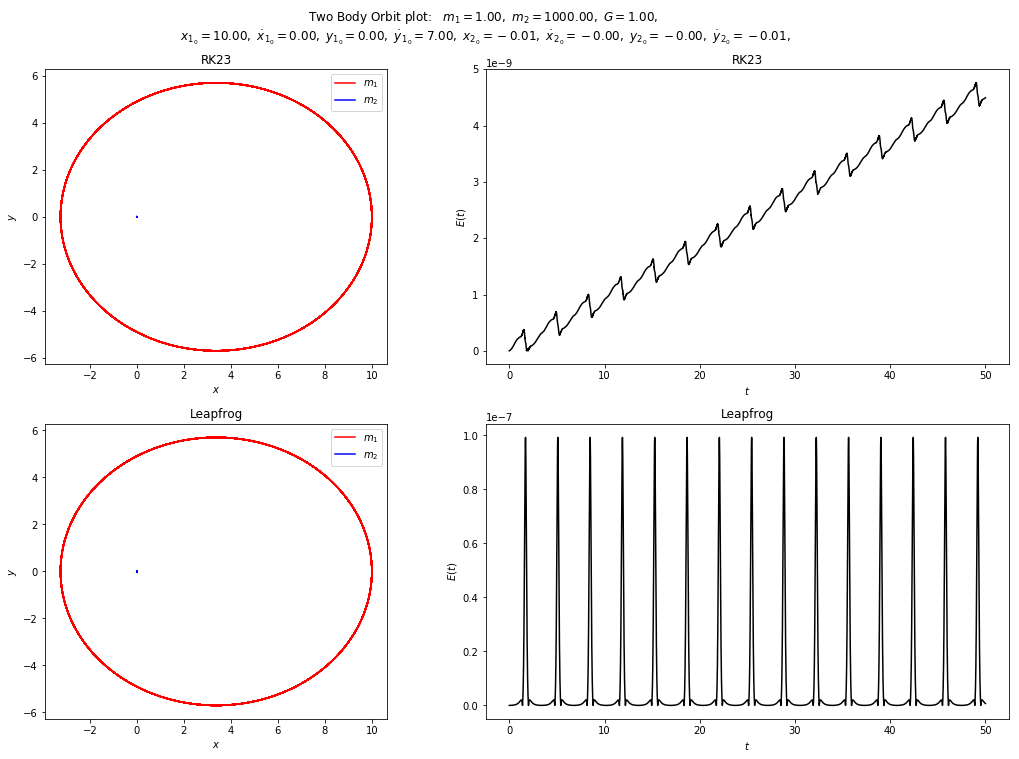

In [9]:
# start the plot!
fig = plt.figure(figsize=(15,10))
overall_title = 'Two Body Orbit plot:  ' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $G = {G:.2f},$' + \
                '\n' + \
                rf' $x_{{1_0}} = {x1_0:.2f},$' + \
                rf' $\dot x_{{1_0}} = {x1_dot_0:.2f},$' + \
                rf' $y_{{1_0}} = {y1_0:.2f},$' + \
                rf' $\dot y_{{1_0}} = {y1_dot_0:.2f},$' + \
                rf' $x_{{2_0}} = {x2_0:.2f},$' + \
                rf' $\dot x_{{2_0}} = {x2_dot_0:.2f},$' + \
                rf' $y_{{2_0}} = {y2_0:.2f},$' + \
                rf' $\dot y_{{2_0}} = {y2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot gravitational orbits of each mass on the same plot  
ax_a = fig.add_subplot(2,2,1)                  

# Get indices to only plot from t=0 to t=50
start, stop = start_stop_indices(t_pts, t_start, 50.)
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_1$', 
            title='RK23', 
            ax=ax_a)
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_2$', 
            title='RK23', 
            ax=ax_a)    
ax_a.set_aspect(1.)

# plot energy difference for the standard ODE solver
ax_a_energy = fig.add_subplot(2,2,2)

# Get indices to only plot from t=0 to t=50
start, stop = start_stop_indices(t_pts, t_start, 50.)    
plot_y_vs_x(t_pts[start : stop], E_rel_diff_pts[start : stop], 
            axis_labels=E_vs_t_labels, 
            color='black',
            label=None, 
            title='RK23', 
            ax=ax_a_energy)  

# Plot gravitational orbits for Leapfrog on the same plot 
ax_b = fig.add_subplot(2,2,3)   

# Get indices to only plot from t=0 to t=50
start, stop = start_stop_indices(t_pts, t_start, 50.)
plot_y_vs_x(x1_LF[start : stop], y1_LF[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_1$', 
            title='Leapfrog', 
            ax=ax_b)
plot_y_vs_x(x2_LF[start : stop], y2_LF[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_2$', 
            title='Leapfrog', 
            ax=ax_b)    
ax_b.set_aspect(1.)

# plot energy difference for the standard ODE solver
ax_b_energy = fig.add_subplot(2,2,4)

# Get indices to only plot from t=0 to t=50
start, stop = start_stop_indices(t_pts, t_start, 50.)    
plot_y_vs_x(t_pts[start : stop], E_rel_diff_pts_LF[start : stop], 
            axis_labels=E_vs_t_labels, 
            color='black',
            label=None, 
            title='Leapfrog', 
            ax=ax_b_energy)  

fig.tight_layout()
fig.savefig('TwoBodyOrbit_Heavy', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'

## Hyperbolic Orbit with $m_2$>>$m_1$

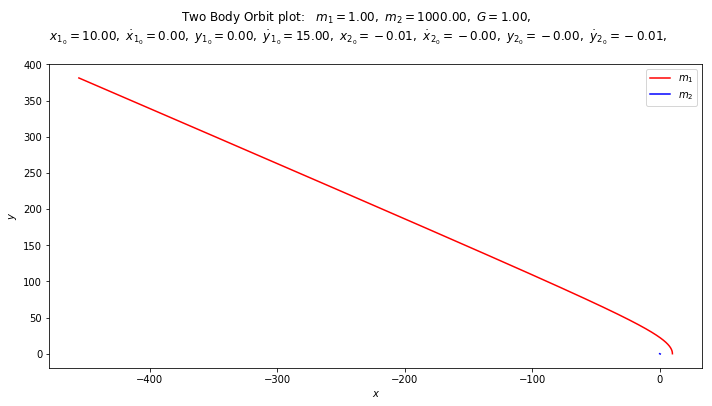

In [10]:
# Initial conditions for the plot
x1_0 = 10.
x1_dot_0 = 0.
y1_0 = 0.
y1_dot_0 = 15.

x2_0 = -mass1*x1_0/mass2
x2_dot_0 = -mass1*x1_dot_0/mass2
y2_0 = -mass1*y1_0/mass2
y2_dot_0 = -mass1*y1_dot_0/mass2

# Solve the differential equation
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o2.solve_ode(t_pts, 
                                                x1_0, x1_dot_0,
                                                y1_0, y1_dot_0,
                                                x2_0, x2_dot_0,
                                                y2_0, y2_dot_0)


# start the plot!
fig = plt.figure(figsize=(10,5))
overall_title = 'Two Body Orbit plot:  ' + \
                rf' $m_1 = {mass1:.2f},$' + \
                rf' $m_2 = {mass2:.2f},$' + \
                rf' $G = {G:.2f},$' + \
                '\n' + \
                rf' $x_{{1_0}} = {x1_0:.2f},$' + \
                rf' $\dot x_{{1_0}} = {x1_dot_0:.2f},$' + \
                rf' $y_{{1_0}} = {y1_0:.2f},$' + \
                rf' $\dot y_{{1_0}} = {y1_dot_0:.2f},$' + \
                rf' $x_{{2_0}} = {x2_0:.2f},$' + \
                rf' $\dot x_{{2_0}} = {x2_dot_0:.2f},$' + \
                rf' $y_{{2_0}} = {y2_0:.2f},$' + \
                rf' $\dot y_{{2_0}} = {y2_dot_0:.2f},$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')
    
# Plot gravitational orbits of each mass on the same plot 
ax_a = fig.add_subplot(1,1,1)                  

# Get indices to only plot from t=0 to t=100
start, stop = start_stop_indices(t_pts, t_start, 100.)
plot_y_vs_x(x1[start : stop], y1[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='red',
            label=r'$m_1$', 
            title=None, 
            ax=ax_a)
plot_y_vs_x(x2[start : stop], y2[start : stop], 
            axis_labels=x_vs_y_labels, 
            color='blue',
            label=r'$m_2$', 
            title=None, 
            ax=ax_a)    


fig.tight_layout()
fig.savefig('TwoBodyOrbit_Heavy_2', bbox_inches='tight', dpi=200.)  # always bbox_inches='tight'